In [46]:
# Compile the graph into class
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from colormap import Color
import datetime
import time
import mplleaflet
import ipywidgets as widgets
import salem
import motionless
from salem import get_demo_file, DataLevels, GoogleVisibleMap, Map


class AllPurpose:
    
    column_name = {'names': 'names',
                   'dates':'dates',
                   'latitude':'latitude',
                   'longitude':'longitude',
                   'categorical': 'categorical',
                   'quant1': 'quant1',
                   'quant2': 'quant2',
                   'quant3': 'quant3'                  
                  }
    
    def __init__(self,data,column_name={}):
        self.data = data
        for key in self.column_name.keys():
            if key in column_name.keys():
                self.column_name[key] = column_name[key]
        self.initColumns()
                
    def initColumns(self):
        self.cnames = self.column_name['names']
        self.cdates = self.column_name['dates']
        self.clatitude = self.column_name['latitude']
        self.clongitude = self.column_name['longitude']
        self.ccategorical = self.column_name['categorical']
        self.cquant1 = self.column_name['quant1']
        self.cquant2 = self.column_name['quant2']
        self.cquant3 = self.column_name['quant3']
        
        
        group_cat = sample.groupby('categorical')['categorical'].count()
        group_cat
        self.cat_dictionary = group_cat.index.values


        
    # Function to generate General statistics plot
    def plotGeneralStat(self, color='Paired'):
        dataFig = plt.figure(figsize=(15,15))
        # make super title
        dataFig.suptitle('General Statistics for Dataset')
        # Make Pie Chart
        ax1 = dataFig.add_subplot(2,2,1)
        plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)    
        freqCat = sample.groupby(self.ccategorical)[self.ccategorical].count()

        
        pie_wedge_collection = ax1.pie(freqCat,labels=freqCat.index)

        # define color map for all categories
        cm = plt.get_cmap(color)
        norm = mpl.colors.Normalize(vmin=0,vmax=len(self.ccategorical))

        i = 0
        colorArr = []
        for pie_wedge in pie_wedge_collection[0]:
            pie_wedge.set_edgecolor('white')
            pie_wedge.set_facecolor(cm(norm(i)))
            colorArr.append(cm(norm(i)))
            i+=1
                    
        ax1.set_title('Category Frequency')
        quant1sum = sample.groupby(self.ccategorical)[self.cquant1].sum()/sample[self.cquant1].sum()
        quant2sum = sample.groupby(self.ccategorical)[self.cquant2].sum()/sample[self.cquant2].sum()
        quant3sum = sample.groupby(self.ccategorical)[self.cquant3].sum()/sample[self.cquant3].sum()

        ax2 = dataFig.add_subplot(2,2,2)
        plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)    
        ax2.bar(range(1,len(quant1sum)+1),quant1sum.values,color=colorArr)
        ax2.set_title('{} Sum Over all Category'.format(self.cquant1))
        ax2.set_xlabel('Category')
        ax2.set_ylabel('Quantity Sum Percentage')
        xticks = plt.xticks(range(1,len(quant1sum)+1),quant1sum.index,rotation=45)

        ax3 = dataFig.add_subplot(2,2,3)
        plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)        
        ax3.bar(range(1,len(quant2sum)+1),quant2sum.values,color=colorArr)
        ax3.set_title('{} Sum Over all Category'.format(self.cquant2))
        ax3.set_xlabel('Category')
        ax3.set_ylabel('Quantity Sum Percentage')
        xticks = plt.xticks(range(1,len(quant2sum)+1),quant2sum.index,rotation=45)


        ax4 = dataFig.add_subplot(2,2,4)    
        plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
        ax4.bar(range(1,len(quant3sum)+1),quant3sum.values,color=colorArr)
        ax4.set_title('{} Sum Over all Category'.format(self.cquant3))
        ax4.set_xlabel('Category')
        ax4.set_ylabel('Quantity Sum Percentage')
        xticks = plt.xticks(range(1,len(quant3sum)+1),quant3sum.index,rotation=45)
        #dataFig.tight_layout() # Or equivalently,  "plt.tight_layout()"
        
    def quantityBin(self,quant,binNumber=12):
        sample = self.data
        # preprocessed dates data for bining
        min_date = sample.dates.min()
        #print(min_date)
        max_date = sample.dates.max()
        #print(max_date)
        #print(max_date - min_date)
        binNum=binNumber+1
        bin_range = np.linspace(min_date,max_date,binNum)

        bin_quant_arr = []
        x_labels = []    

        # calculate the quantity variables for each bins
        for i in range(len(bin_range)-1):
            #print(bin_range[i])
            bin_sample = sample[(sample[self.cdates]>=bin_range[i])&(sample[self.cdates]<bin_range[i+1])]
            #print(len(bin_sample))
            bin_sums = bin_sample.groupby(self.ccategorical)[quant].sum()
            bin_mean = bin_sample.groupby(self.ccategorical)[quant].mean()
            bin_max = bin_sample.groupby(self.ccategorical)[quant].min()
            bin_min = bin_sample.groupby(self.ccategorical)[quant].max()
            bin_sd = bin_sample.groupby(self.ccategorical)[quant].std()
            zipped = pd.concat([bin_sums,bin_mean,bin_max,bin_min,bin_sd],join='inner',axis=1)
            bin_quant_arr.append(zipped)
            # add labels
            x_labels.append(datetime.datetime.fromtimestamp(bin_range[i]).strftime('%d/%m/%y'))

        x_labels.append(datetime.datetime.fromtimestamp(bin_range[i+1]).strftime('%d/%m/%y'))    

        #print(bin_quant_arr)

        categories = sample.categorical.unique()
        # prepare the array
        bin_cat_arr = {}
        for cat in categories:
            #bin_cat_arr[cat] = pd.DataFrame()
            bin_cat_arr[cat] = []

        for bin_quant in bin_quant_arr:
            for cat in categories:
                if cat in bin_quant.index:                
                    bin_cat_arr[cat].append(bin_quant.loc[cat]) 
                    #bin_cat_arr[cat] = pd.concat([bin_cat_arr[cat],bin_quant.loc[cat]],join='inner',axis=1)
                else:
                    bin_cat_arr[cat].append(np.zeros(5))
                    #bin_cat_arr[cat] = pd.concat([bin_cat_arr[cat],np.zeros(5)],join='inner',axis=1)
        return (bin_cat_arr,x_labels)            

    def show_quantity(self,categories,quant,shows,binNumber,color='viridis'):
        sample_fig = plt.figure(figsize=(15,15));
        sample_ax = sample_fig.add_subplot(1,1,1)
        (qBin,x_labels) = self.quantityBin(quant,binNumber)
        qBin = pd.DataFrame(qBin)
        #print()
        #ax.scatter(obs_stops['stop_lon'], obs_stops['stop_lat'],c=obs_stops.frequency,cmap=plt.get_cmap('viridis'),vmin=min_freq,vmax=max_freq,s=100,alpha=0.5,edgecolors='none')
        #color='viridis'
        # define color map for all categories
        cm = plt.get_cmap(color)
        colorArr = {}
        norm = mpl.colors.Normalize(vmin=0,vmax=len(categories))
        for i in range(len(categories)):
            color = cm(norm(i))
            colorArr[categories[i]] = color

        patch_array = []

        x_position = np.array(range(len(x_labels)-1)) + 0.5

        for cat in categories:
            bin_cat_arr = qBin[cat]
            plot_arr = {}
            # initialize plot_arr
            for i in range(len(bin_cat_arr[0].index)):
                plot_arr[i] = []
            for bin_cat in bin_cat_arr:
                for i in range(len(bin_cat.index)):
                    plot_arr[i].append(bin_cat.values[i])

            if 'Mean' in shows:
                #sample_ax.plot(range(1,len(plot_arr[1])+1),plot_arr[1],'-',c=colorArr[cat])
                sample_ax.plot(x_position.tolist(),plot_arr[1],'-',c=colorArr[cat])

            if '1-SD' in shows:
                #sample_ax.plot(range(1,len(plot_arr[1])+1),np.array(plot_arr[1])-np.array(plot_arr[4]),c=colorArr[cat],linestyle='--')
                #sample_ax.plot(range(1,len(plot_arr[1])+1),np.array(plot_arr[1])+np.array(plot_arr[4]),c=colorArr[cat],linestyle='--')
                sample_ax.plot(x_position.tolist(),np.array(plot_arr[1])-np.array(plot_arr[4]),c=colorArr[cat],linestyle='--')
                sample_ax.plot(x_position.tolist(),np.array(plot_arr[1])+np.array(plot_arr[4]),c=colorArr[cat],linestyle='--')

            if 'Min' in shows:
                #sample_ax.plot(range(1,len(plot_arr[2])+1),plot_arr[2],'-.',c=colorArr[cat])
                sample_ax.plot(x_position.tolist(),plot_arr[2],'-.',c=colorArr[cat])
            if 'Max' in shows:
                #sample_ax.plot(range(1,len(plot_arr[3])+1),plot_arr[3],'-.',c=colorArr[cat])
                sample_ax.plot(x_position.tolist(),plot_arr[3],'-.',c=colorArr[cat])

            patch_array.append(mpl.patches.Patch(color=colorArr[cat],label=cat))

        xticks = plt.xticks(range(len(x_labels)),x_labels,rotation=45)

        sample_ax.legend(handles=patch_array, loc='center left', bbox_to_anchor=(1, 0.5))    

        sample_ax.set_xlabel('Time')
        sample_ax.set_ylabel('Quantity')
        sample_ax.set_title('Quantity Statistics Overtime')
        
    def plotDetailStat(self):
        selectCategory = widgets.SelectMultiple(
            options = self.cat_dictionary.tolist(),
            value=[self.cat_dictionary[0]],
            description='Category'
        )

        dropdownQuantity = widgets.Dropdown(
            options = [self.cquant1,self.cquant2,self.cquant3],
            value=self.cquant1,
            description='Quantity Column'
        )

        selectCustomViz = widgets.SelectMultiple(
            options = ['Mean','Min','Max','1-SD'],
            value=['Mean','1-SD'],
            description='Show'
        )

        
        # print color_map
        allcmap = plt.colormaps()
        
        cmapArr = []
        for cmap in allcmap:
            if '_r' not in cmap:
                cmapArr.append(cmap)
        
        
        dropdownCmap = widgets.Dropdown(
            options = cmapArr,
            value='viridis',
            description='Color'
        )     
        
        sliderBin = widgets.IntSlider(
            value=12,
            min=12,
            max=80,
            step=1,
            description='Date Binning:',
            orientation='horizontal',
            readout=True,
            readout_format='i',
            slider_color='white'
        )

        widgets.interact(self.show_quantity,categories=selectCategory,quant=dropdownQuantity,shows=selectCustomViz,binNumber=sliderBin,color=dropdownCmap)
        
        
    def spatial_bin_plot(self,category,quantity,bin_step=20,color='viridis'):
        # scale Dimension
        scaleDim = 5

        # Binning base on spatial
        data = self.data
        # filter the data by category
        data = data[data[self.ccategorical].isin(category)]
        # This maximum constant is what we can get from
        # the google map static image
        # greater or lower than these can produce error
        maxconst = (-86.82743293, 86.92841107, -176.1111116, 176.4292565)
        minlat = data[self.clatitude].min() if data[self.clatitude].min() > maxconst[0] else maxconst[0];
        maxlat = data[self.clatitude].max() if data[self.clatitude].max() < maxconst[1] else maxconst[1];
        minlong = data[self.clongitude].min() if data[self.clongitude].min() > maxconst[2] else maxconst[2];
        maxlong = data[self.clongitude].max() if data[self.clongitude].max() < maxconst[3] else maxconst[3];
        #print(minlat,maxlat,minlong,maxlong)
        g = GoogleVisibleMap(x=[minlong, maxlong], y=[minlat, maxlat],
                         maptype='terrain')  # satellitetry out also: 'terrain'    

        # the google static image is a standard rgb image
        ggl_img = g.get_vardata()
        #ax.imshow(ggl_img)
        # make a map of the same size as the image (no country borders)
        sm = Map(g.grid, factor=1, countries=False)
        sm.set_rgb(ggl_img)  # add the background rgb image    

        #print(minlat,maxlat,minlong,maxlong)
        # make range for Latitude
        # set step
        xstep = bin_step
        ystep = bin_step
        latBin = np.linspace(data[self.clatitude].min(),data[self.clatitude].max(),xstep);
        longBin = np.linspace(data[self.clongitude].min(),data[self.clongitude].max(),ystep)
        #logger.debug(latBin)
        #print(longBin)

        quantBinArr = []
        quantmeanArr = []
        quantsumArr = []

        latStepLen = latBin[1] - latBin[0]
        longStepLen = longBin[1] - longBin[0]

        #treesWithoutVacant = trees.filter_ne('Tree Species','vacant site large')
        for x in range(latBin.size):    
            if(x < latBin.size-1):
                latSelMin = latBin[x] if latBin[x] < latBin[x+1] else latBin[x+1]
                latSelMax = latBin[x] if latBin[x] > latBin[x+1] else latBin[x+1]

                #latData = data[(data['latitude']>latBin[x])&(data['latitude']<=latBin[x+1])]
                latData = data[(data[self.clatitude]>latSelMin)&(data[self.clatitude]<=latSelMax)]
                latmean = latSelMin + (latStepLen/2)
                for y in range(longBin.size):
                    if(y < longBin.size-1):
                        lonSelMin = longBin[y] if longBin[y] < longBin[y+1] else longBin[y+1]
                        lonSelMax = longBin[y] if longBin[y] > longBin[y+1] else longBin[y+1]                    

                        #print(lonSelMin,lonSelMax)
                        #print((latData['longitude']>lonSelMin)&(latData['longitude']<=lonSelMax))

                        #areaData = latData[(latData['longitude']>longBin[y])&latData['longitude']<longBin[y+1]]
                        areaData = latData[(latData[self.clongitude]>lonSelMin)&(latData[self.clongitude]<=lonSelMax)]
                        #print(areaData.shape)
                        # group the areaData by category to get the mean and sum category
                        meanCat = areaData.groupby(self.ccategorical)[quantity].mean().sort_values(ascending=False)
                        sumCat = areaData.groupby(self.ccategorical)[quantity].sum().sort_values(ascending=False)

                        """
                        # get mean for the quantity area bin
                        quantmean = areaData[quantity].mean()
                        quantsum = areaData[quantity].sum()
                        """
                        if areaData.shape[0] > 0:
                            longmean = lonSelMin + (longStepLen/2)
                            quantmeanArr.append(meanCat.max())
                            quantsumArr.append(sumCat.max())
                            #print(meanCat)
                            #print(sumCat)
                            quantBinArr.append({'lat': latmean, 'long': longmean, 'mean': meanCat, 'sum': sumCat})
                            """
                            quantmeanArr.append(quantmean)
                            quantsumArr.append(quantsum)
                            longmean = (longBin[y]+longBin[y+1])/2
                            quantBinArr.append({'lat': latmean, 'long': longmean, 'quantmean': quantmean, 'quantsum': quantsum})
                            """

        dataFig = plt.figure(figsize=(15,15))
        loc_ax = dataFig.add_subplot(1,1,1)
        sm.visualize(ax=loc_ax)  # plot it

    #    loc_ax.set_title('Distribution of Most Common Trees accross Spatial Binning: {}x{} square'.format(xstep,ystep))
        loc_ax.set_xlabel('Longitude')
        loc_ax.set_ylabel('Latitude')

        minMean = np.array(quantmeanArr).min()
        maxMean = np.array(quantmeanArr).max()
        # calculate the scale
        # we scale it using 8 level
        scale = (maxMean - minMean) / scaleDim

        scale_array = []   
        scale_label = []
        # Make scale legend
        for i in range(scaleDim):
            #patch_array.append(mpl.patches.Patch(color='none',label=i,))
            scale_array.append(plt.scatter([],[],s=(i+1)*(longStepLen/2)*scaleDim,marker='o',color='#555555'))
            scale_label.append('{0:.2f} < x <= {1:.2f}'.format(minMean+(scale*i),minMean+(scale*(i+1))))

        #define color representation for each category
        cm = plt.get_cmap(color)
        colorArr = {}
        norm = mpl.colors.Normalize(vmin=0,vmax=len(category))

        patch_array = []
        for i in range(len(category)):
            color = cm(norm(i))
            colorArr[category[i]] = color
            patch_array.append(mpl.patches.Patch(color=color,label=category[i]))

        for quantBin in quantBinArr:
            x, y = sm.grid.transform(quantBin['long'],quantBin['lat'])        
            scatter = loc_ax.scatter(x,y,s=(quantBin['mean'].values[0]/scale)*(longStepLen/2)*scaleDim,c=colorArr[quantBin['mean'].index[0]],alpha=.75,edgecolors='none')        
            #tooltip = plugins.PointHTMLTooltip(scatter, ['test'])
            #plugins.connect(dataFig, tooltip)

        # Legend and Title        
        #legend2 = mpl.pyplot.legend(handles=scale_array, loc=1)
        legend2 = mpl.pyplot.legend(scale_array,
           scale_label,
           scatterpoints=1,
           loc='upper right',
           ncol=1,
            bbox_to_anchor=(1, 1)
            #,fontsize=8
                                   )

        #legend1 = mpl.pyplot.legend(handles=patch_array, loc=4,bbox_to_anchor=(1, 0.5))
        loc_ax.legend(handles=patch_array, loc='center left', bbox_to_anchor=(1, 0.5))
        mpl.pyplot.gca().add_artist(legend2)

        loc_ax.set_title('Quantity {} across Spatial Bining'.format(quantity))

        #mpld3.enable_notebook()

        return None
    
    def plotSpatialStat(self):
        selectCategory = widgets.SelectMultiple(
            options = self.cat_dictionary.tolist(),
            value=[self.cat_dictionary[0]],
            description='Category'
        )

        dropdownQuantity = widgets.Dropdown(
            options = [self.cquant1,self.cquant2,self.cquant3],
            value=self.cquant1,
            description='Quantity Column'
        )
        
        # print color_map
        allcmap = plt.colormaps()
        
        cmapArr = []
        for cmap in allcmap:
            if '_r' not in cmap:
                cmapArr.append(cmap)
        
        
        dropdownCmap = widgets.Dropdown(
            options = cmapArr,
            value='viridis',
            description='Color'
        )     
            
        sliderBin = widgets.IntSlider(
            value=10,
            min=10,
            max=100,
            step=1,
            description='Spatial Binning:',
            orientation='horizontal',
            readout=True,
            readout_format='i',
            slider_color='white'
        )

        widgets.interact(self.spatial_bin_plot,category=selectCategory,quantity=dropdownQuantity,bin_step=sliderBin,color=dropdownCmap)


In [47]:
# read generic dataset
# sample_flat.csv
%matplotlib inline
sample = pd.read_csv('sample_flat.csv')

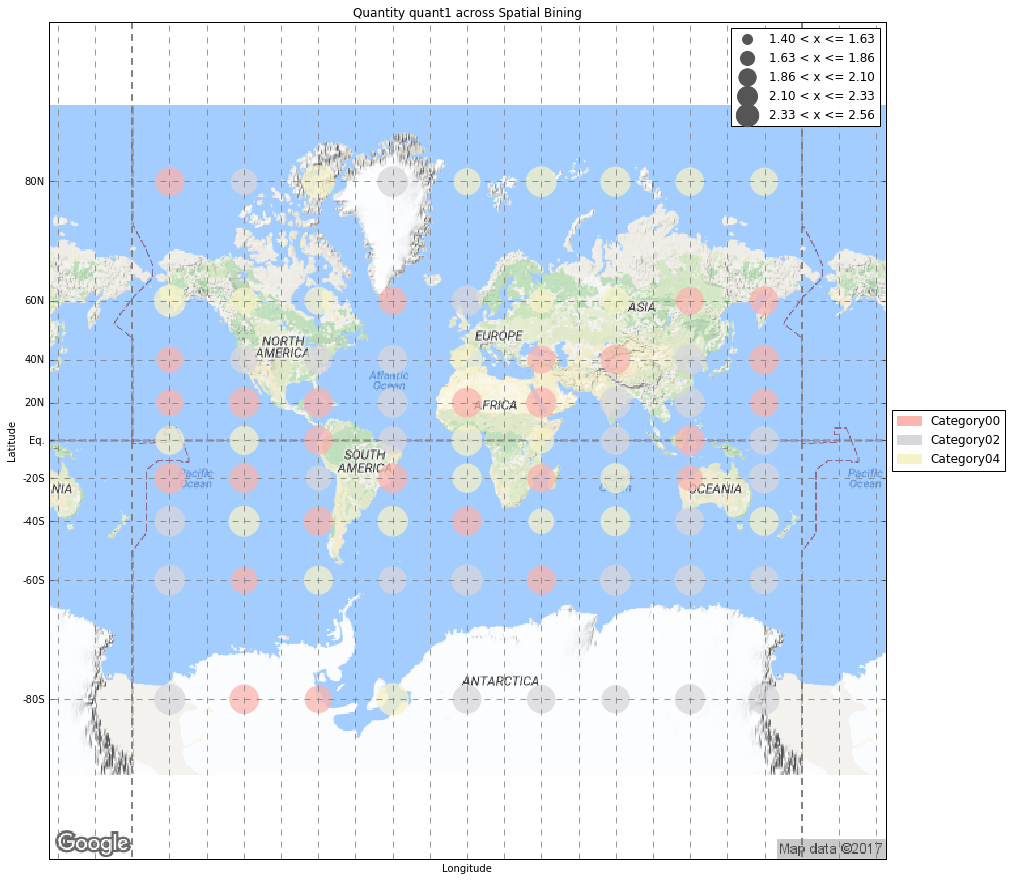

In [48]:
test = AllPurpose(sample)
test.plotSpatialStat()

In [61]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from colormap import Color
import datetime
import time
import mplleaflet
import ipywidgets as widgets

%matplotlib inline

#logging
import logging
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger.debug('Test Debug')

In [204]:
sample

,names,dates,latitude,longitude,categorical,quant1,quant2,quant3,real_time
0,b'Rawad',1453008863,-19.988651,-41.435565,Category01,1.933239,6.052785,6105.123120,2016-01-16 23:34:23
1,b'Eurma',1471778579,-8.593256,27.742604,Category00,1.520733,-11.065076,143.902725,2016-08-21 06:22:59
2,b'Taleia',1473613446,-67.463164,-109.366796,Category04,1.863466,11.437340,2019.370225,2016-09-11 12:04:06
3,b'Niley',1481194251,-7.537010,-32.218540,Category03,0.745431,19.415543,3225.920647,2016-12-08 04:50:51
4,b'Acey',1454402794,-17.116866,2.949914,Category05,1.031100,17.714492,4976.099324,2016-02-02 02:46:34
5,b'Obert',1463099041,86.050560,-138.759294,Category00,0.820424,-28.240086,9725.990286,2016-05-12 19:24:01
6,b'Kadel',1481065733,53.965137,-174.545084,Category04,3.485479,9.613104,8133.741192,2016-12-06 17:08:53
7,b'Jaiyanna',1461933123,37.910119,-135.568743,Category04,0.635373,-0.084906,8340.323743,2016-04-29 07:32:03
8,b'Haylei',1469302986,-79.231809,168.419140,Category07,0.802668,17.993627,4695.368570,2016-07-23 14:43:06
9,b'Ayhem',1454702028,33.318067,56.065283,Category09,2.353746,-9.800971,1558.909278,2016-02-05 13:53:48


In [3]:
sample['real_time'] = sample.dates.apply(lambda x: datetime.datetime.fromtimestamp(x))

In [4]:
# Frequency of category
# and distinct all the value in the category into category dictionary
group_cat = sample.groupby('categorical')['categorical'].count()
group_cat
cat_dictionary = group_cat.index.values
cat_dictionary

array(['Category00', 'Category01', 'Category02', 'Category03',
       'Category04', 'Category05', 'Category06', 'Category07',
       'Category08', 'Category09'], dtype=object)

In [6]:
# preprocessed dates data for bining
min_date = sample.dates.min()
#print(min_date)
max_date = sample.dates.max()
#print(max_date)
#print(max_date - min_date)
binNum=12
bin_range = np.linspace(min_date,max_date,binNum)

bin_quant_arr = []
# calculate the quantity variables for each bins
for i in range(len(bin_range)-1):
    #print(bin_range[i])
    bin_sample = sample[(sample['dates']>=bin_range[i])&(sample['dates']<bin_range[i+1])]
    #print(len(bin_sample))
    bin_sums = bin_sample.groupby('categorical')['quant1'].sum()
    bin_mean = bin_sample.groupby('categorical')['quant1'].mean()
    #bin_sd = bin_sample.groupby('categorical')['quant1'].sd()
    bin_quant_arr.append((bin_sums,bin_mean))

In [7]:
#plot the category
# get unique values for category
categories = sample.categorical.unique()
# prepare the array
bin_cat_arr = {}
bin_cat_mean = {}
for cat in categories:
    bin_cat_arr[cat] = []
    bin_cat_mean[cat] = []

for bin_quant in bin_quant_arr:    
    bin_quant_obs = bin_quant[0]
    bin_mean_obs = bin_quant[1]
    for cat in categories:
        if cat in bin_quant_obs.index:
            bin_cat_arr[cat].append(bin_quant_obs[cat]) 
            bin_cat_mean[cat].append(bin_mean_obs[cat])
        else:
            bin_cat_arr[cat].append(0)
            bin_cat_mean[cat].append(0)


In [8]:
def quantityBin(quant,binNumber=12):
    # preprocessed dates data for bining
    min_date = sample.dates.min()
    #print(min_date)
    max_date = sample.dates.max()
    #print(max_date)
    #print(max_date - min_date)
    binNum=binNumber+1
    bin_range = np.linspace(min_date,max_date,binNum)

    bin_quant_arr = []
    x_labels = []    
    
    # calculate the quantity variables for each bins
    for i in range(len(bin_range)-1):
        #print(bin_range[i])
        bin_sample = sample[(sample['dates']>=bin_range[i])&(sample['dates']<bin_range[i+1])]
        #print(len(bin_sample))
        bin_sums = bin_sample.groupby('categorical')[quant].sum()
        bin_mean = bin_sample.groupby('categorical')[quant].mean()
        bin_max = bin_sample.groupby('categorical')[quant].min()
        bin_min = bin_sample.groupby('categorical')[quant].max()
        bin_sd = bin_sample.groupby('categorical')[quant].std()
        zipped = pd.concat([bin_sums,bin_mean,bin_max,bin_min,bin_sd],join='inner',axis=1)
        bin_quant_arr.append(zipped)
        # add labels
        x_labels.append(datetime.datetime.fromtimestamp(bin_range[i]).strftime('%d/%m/%y'))

    x_labels.append(datetime.datetime.fromtimestamp(bin_range[i+1]).strftime('%d/%m/%y'))    
    
    #print(bin_quant_arr)
    
    categories = sample.categorical.unique()
    # prepare the array
    bin_cat_arr = {}
    for cat in categories:
        #bin_cat_arr[cat] = pd.DataFrame()
        bin_cat_arr[cat] = []

    for bin_quant in bin_quant_arr:
        for cat in categories:
            if cat in bin_quant.index:                
                bin_cat_arr[cat].append(bin_quant.loc[cat]) 
                #bin_cat_arr[cat] = pd.concat([bin_cat_arr[cat],bin_quant.loc[cat]],join='inner',axis=1)
            else:
                bin_cat_arr[cat].append(np.zeros(5))
                #bin_cat_arr[cat] = pd.concat([bin_cat_arr[cat],np.zeros(5)],join='inner',axis=1)
    return (bin_cat_arr,x_labels)    

In [9]:
def show_quantity(categories,quant,shows,binNumber):
    sample_fig = plt.figure(figsize=(15,15));
    sample_ax = sample_fig.add_subplot(1,1,1)
    (qBin,x_labels) = quantityBin(quant,binNumber)
    qBin = pd.DataFrame(qBin)
#    print()
#    ax.scatter(obs_stops['stop_lon'], obs_stops['stop_lat'],c=obs_stops.frequency,cmap=plt.get_cmap('viridis'),vmin=min_freq,vmax=max_freq,s=100,alpha=0.5,edgecolors='none')
    color='viridis'
    # define color map for all categories
    cm = plt.get_cmap(color)
    colorArr = {}
    norm = mpl.colors.Normalize(vmin=0,vmax=len(categories))
    for i in range(len(categories)):
        color = cm(norm(i))
        colorArr[categories[i]] = color

    patch_array = []
    
    x_position = np.array(range(len(x_labels)-1)) + 0.5
    
    for cat in categories:
        bin_cat_arr = qBin[cat]
        plot_arr = {}
        # initialize plot_arr
        for i in range(len(bin_cat_arr[0].index)):
            plot_arr[i] = []
        for bin_cat in bin_cat_arr:
            for i in range(len(bin_cat.index)):
                plot_arr[i].append(bin_cat.values[i])
        
        if 'Mean' in shows:
            #sample_ax.plot(range(1,len(plot_arr[1])+1),plot_arr[1],'-',c=colorArr[cat])
            sample_ax.plot(x_position.tolist(),plot_arr[1],'-',c=colorArr[cat])
        
        if '1-SD' in shows:
            #sample_ax.plot(range(1,len(plot_arr[1])+1),np.array(plot_arr[1])-np.array(plot_arr[4]),c=colorArr[cat],linestyle='--')
            #sample_ax.plot(range(1,len(plot_arr[1])+1),np.array(plot_arr[1])+np.array(plot_arr[4]),c=colorArr[cat],linestyle='--')
            sample_ax.plot(x_position.tolist(),np.array(plot_arr[1])-np.array(plot_arr[4]),c=colorArr[cat],linestyle='--')
            sample_ax.plot(x_position.tolist(),np.array(plot_arr[1])+np.array(plot_arr[4]),c=colorArr[cat],linestyle='--')

        if 'Min' in shows:
            #sample_ax.plot(range(1,len(plot_arr[2])+1),plot_arr[2],'-.',c=colorArr[cat])
            sample_ax.plot(x_position.tolist(),plot_arr[2],'-.',c=colorArr[cat])
        if 'Max' in shows:
            #sample_ax.plot(range(1,len(plot_arr[3])+1),plot_arr[3],'-.',c=colorArr[cat])
            sample_ax.plot(x_position.tolist(),plot_arr[3],'-.',c=colorArr[cat])

        patch_array.append(mpl.patches.Patch(color=colorArr[cat],label=cat))
        
    xticks = plt.xticks(range(len(x_labels)),x_labels,rotation=45)

    sample_ax.legend(handles=patch_array, loc='center left', bbox_to_anchor=(1, 0.5))    
    
    sample_ax.set_xlabel('Time')
    sample_ax.set_ylabel('Quantity')
    sample_ax.set_title('Quantity Statistics Overtime')
            
#bin_cat_arr['Category00']

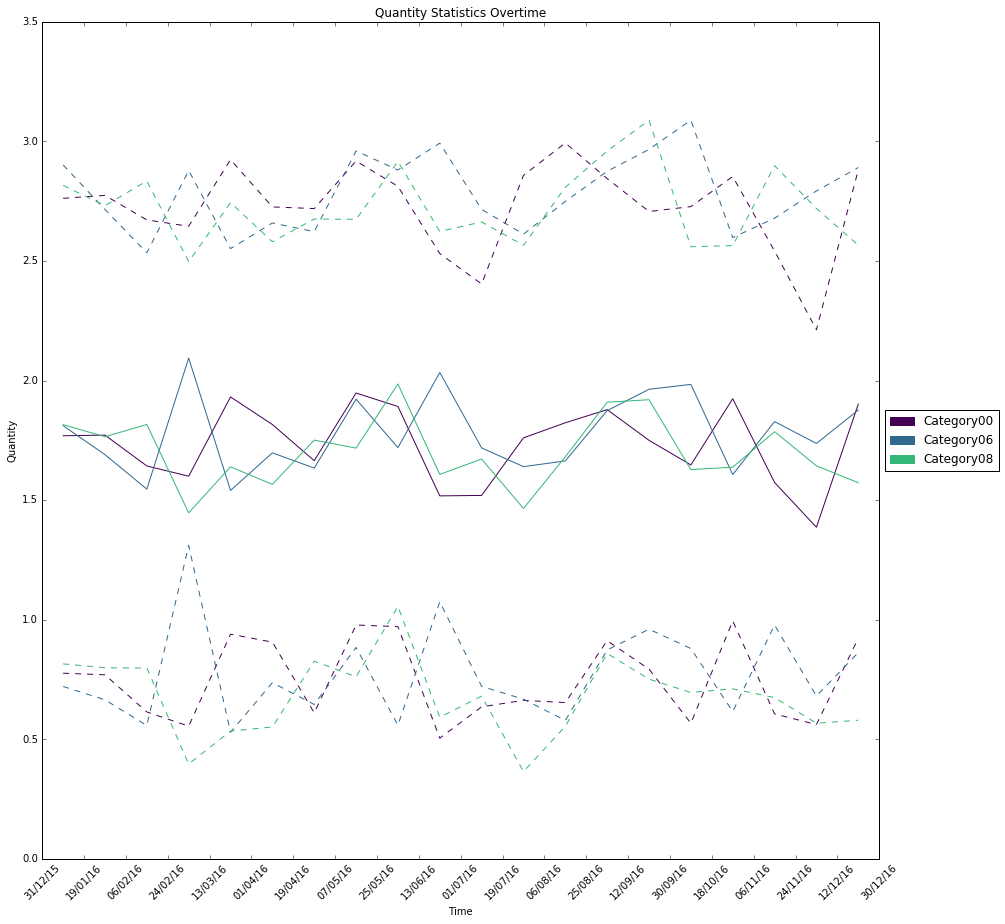

In [10]:
import ipywidgets as widgets
selectCategory = widgets.SelectMultiple(
    options = cat_dictionary.tolist(),
    value=[cat_dictionary[0]],
    description='Category'
)

dropdownQuantity = widgets.Dropdown(
    options = ['quant1','quant2','quant3'],
    value='quant1',
    description='Quantity Column'
)

selectCustomViz = widgets.SelectMultiple(
    options = ['Mean','Min','Max','1-SD'],
    value=['Mean','1-SD'],
    description='Show'
)

sliderBin = widgets.IntSlider(
    value=12,
    min=12,
    max=80,
    step=1,
    description='Date Binning:',
    orientation='horizontal',
    readout=True,
    readout_format='i',
    slider_color='white'
)

widgets.interact(show_quantity,categories=selectCategory,quant=dropdownQuantity,shows=selectCustomViz,binNumber=sliderBin)

In [178]:
import salem
import motionless
from salem import get_demo_file, DataLevels, GoogleVisibleMap, Map
#from mpld3 import plugins
#import mpld3

# function to plot the trees based on spatial bining
def spatial_bin_plot(category,quantity,bin_step=20):
    # scale Dimension
    scaleDim = 5
    
    # Binning base on spatial
    data = sample
    # filter the data by category
    data = data[data['categorical'].isin(category)]
    # This maximum constant is what we can get from
    # the google map static image
    # greater or lower than these can produce error
    maxconst = (-86.82743293, 86.92841107, -176.1111116, 176.4292565)
    minlat = data['latitude'].min() if data['latitude'].min() > maxconst[0] else maxconst[0];
    maxlat = data['latitude'].max() if data['latitude'].max() < maxconst[1] else maxconst[1];
    minlong = data['longitude'].min() if data['longitude'].min() > maxconst[2] else maxconst[2];
    maxlong = data['longitude'].max() if data['longitude'].max() < maxconst[3] else maxconst[3];
    #print(minlat,maxlat,minlong,maxlong)
    g = GoogleVisibleMap(x=[minlong, maxlong], y=[minlat, maxlat],
                     maptype='terrain')  # satellitetry out also: 'terrain'    
    
    # the google static image is a standard rgb image
    ggl_img = g.get_vardata()
    #ax.imshow(ggl_img)
    # make a map of the same size as the image (no country borders)
    sm = Map(g.grid, factor=1, countries=False)
    sm.set_rgb(ggl_img)  # add the background rgb image    
    
    #print(minlat,maxlat,minlong,maxlong)
    # make range for Latitude
    # set step
    xstep = bin_step
    ystep = bin_step
    latBin = np.linspace(data['latitude'].min(),data['latitude'].max(),xstep);
    longBin = np.linspace(data['longitude'].min(),data['longitude'].max(),ystep)
    logger.debug(latBin)
    #print(longBin)

    quantBinArr = []
    quantmeanArr = []
    quantsumArr = []
    
    latStepLen = latBin[1] - latBin[0]
    longStepLen = longBin[1] - longBin[0]
    
    #treesWithoutVacant = trees.filter_ne('Tree Species','vacant site large')
    for x in range(latBin.size):    
        if(x < latBin.size-1):
            latSelMin = latBin[x] if latBin[x] < latBin[x+1] else latBin[x+1]
            latSelMax = latBin[x] if latBin[x] > latBin[x+1] else latBin[x+1]
            
            #latData = data[(data['latitude']>latBin[x])&(data['latitude']<=latBin[x+1])]
            latData = data[(data['latitude']>latSelMin)&(data['latitude']<=latSelMax)]
            latmean = latSelMin + (latStepLen/2)
            for y in range(longBin.size):
                if(y < longBin.size-1):
                    lonSelMin = longBin[y] if longBin[y] < longBin[y+1] else longBin[y+1]
                    lonSelMax = longBin[y] if longBin[y] > longBin[y+1] else longBin[y+1]                    

                    #print(lonSelMin,lonSelMax)
                    #print((latData['longitude']>lonSelMin)&(latData['longitude']<=lonSelMax))
                    
                    #areaData = latData[(latData['longitude']>longBin[y])&latData['longitude']<longBin[y+1]]
                    areaData = latData[(latData['longitude']>lonSelMin)&(latData['longitude']<=lonSelMax)]
                    #print(areaData.shape)
                    # group the areaData by category to get the mean and sum category
                    meanCat = areaData.groupby('categorical')[quantity].mean().sort_values(ascending=False)
                    sumCat = areaData.groupby('categorical')[quantity].sum().sort_values(ascending=False)
                    
                    """
                    # get mean for the quantity area bin
                    quantmean = areaData[quantity].mean()
                    quantsum = areaData[quantity].sum()
                    """
                    if areaData.shape[0] > 0:
                        longmean = lonSelMin + (longStepLen/2)
                        quantmeanArr.append(meanCat.max())
                        quantsumArr.append(sumCat.max())
                        #print(meanCat)
                        #print(sumCat)
                        quantBinArr.append({'lat': latmean, 'long': longmean, 'mean': meanCat, 'sum': sumCat})
                        """
                        quantmeanArr.append(quantmean)
                        quantsumArr.append(quantsum)
                        longmean = (longBin[y]+longBin[y+1])/2
                        quantBinArr.append({'lat': latmean, 'long': longmean, 'quantmean': quantmean, 'quantsum': quantsum})
                        """
                        
    dataFig = plt.figure(figsize=(15,15))
    loc_ax = dataFig.add_subplot(1,1,1)
    sm.visualize(ax=loc_ax)  # plot it

#    loc_ax.set_title('Distribution of Most Common Trees accross Spatial Binning: {}x{} square'.format(xstep,ystep))
    loc_ax.set_xlabel('Longitude')
    loc_ax.set_ylabel('Latitude')
    
    minMean = np.array(quantmeanArr).min()
    maxMean = np.array(quantmeanArr).max()
    # calculate the scale
    # we scale it using 8 level
    scale = (maxMean - minMean) / scaleDim
    
    scale_array = []   
    scale_label = []
    # Make scale legend
    for i in range(scaleDim):
        #patch_array.append(mpl.patches.Patch(color='none',label=i,))
        scale_array.append(plt.scatter([],[],s=(i+1)*(longStepLen/2)*scaleDim,marker='o',color='#555555'))
        scale_label.append('{0:.2f} < x <= {1:.2f}'.format(minMean+(scale*i),minMean+(scale*(i+1))))
        
    #define color representation for each category
    color='viridis'
    cm = plt.get_cmap(color)
    colorArr = {}
    norm = mpl.colors.Normalize(vmin=0,vmax=len(category))
    
    patch_array = []
    for i in range(len(category)):
        color = cm(norm(i))
        colorArr[category[i]] = color
        patch_array.append(mpl.patches.Patch(color=color,label=category[i]))
        
    for quantBin in quantBinArr:
        x, y = sm.grid.transform(quantBin['long'],quantBin['lat'])        
        scatter = loc_ax.scatter(x,y,s=(quantBin['mean'].values[0]/scale)*(longStepLen/2)*scaleDim,c=colorArr[quantBin['mean'].index[0]],alpha=.75,edgecolors='none')        
        #tooltip = plugins.PointHTMLTooltip(scatter, ['test'])
        #plugins.connect(dataFig, tooltip)
        
    # Legend and Title        
    #legend2 = mpl.pyplot.legend(handles=scale_array, loc=1)
    legend2 = mpl.pyplot.legend(scale_array,
       scale_label,
       scatterpoints=1,
       loc='upper right',
       ncol=1,
        bbox_to_anchor=(1, 1)
        #,fontsize=8
                               )

    #legend1 = mpl.pyplot.legend(handles=patch_array, loc=4,bbox_to_anchor=(1, 0.5))
    loc_ax.legend(handles=patch_array, loc='center left', bbox_to_anchor=(1, 0.5))
    mpl.pyplot.gca().add_artist(legend2)
    
    loc_ax.set_title('Quantity {} across Spatial Bining'.format(quantity))

    #mpld3.enable_notebook()

    return None


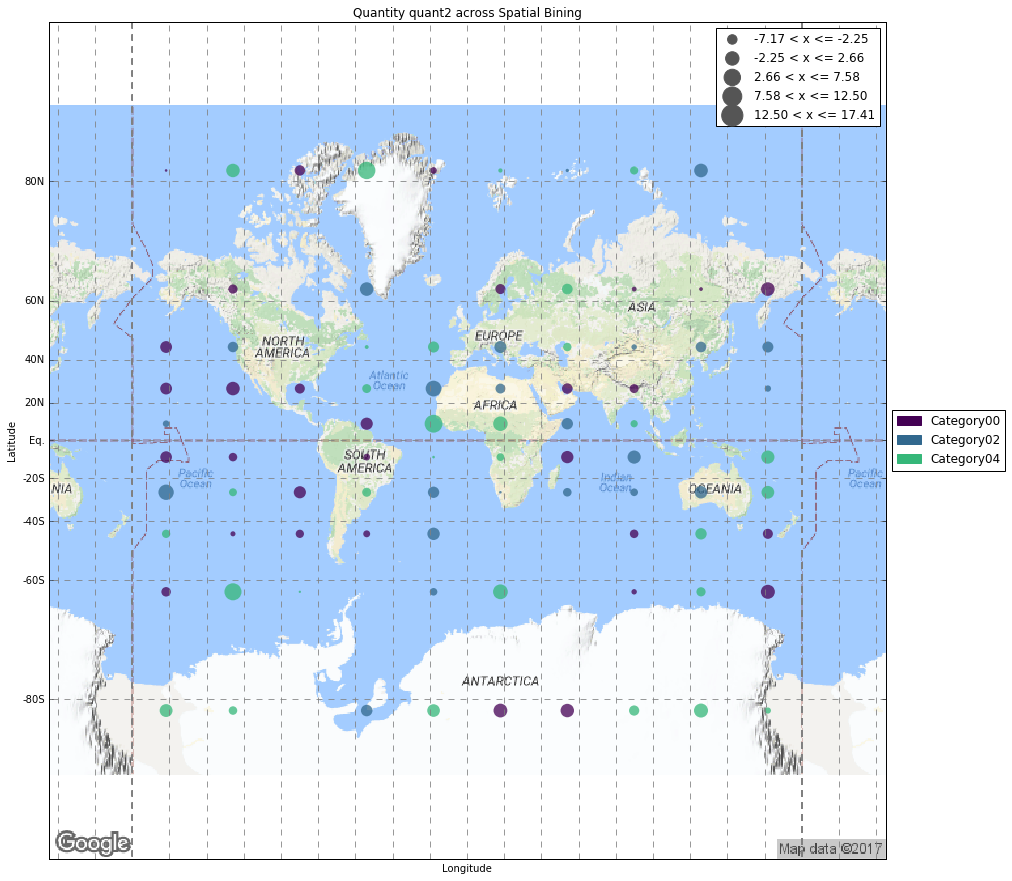

In [179]:
selectCategory = widgets.SelectMultiple(
    options = cat_dictionary.tolist(),
    value=[cat_dictionary[0]],
    description='Category'
)

dropdownQuantity = widgets.Dropdown(
    options = ['quant1','quant2','quant3'],
    value='quant1',
    description='Quantity Column'
)

sliderBin = widgets.IntSlider(
    value=10,
    min=10,
    max=100,
    step=1,
    description='Spatial Binning:',
    orientation='horizontal',
    readout=True,
    readout_format='i',
    slider_color='white'
)

widgets.interact(spatial_bin_plot,category=selectCategory,quantity=dropdownQuantity,bin_step=sliderBin)
#def spatial_bin_plot(data,category,quantity,bin_step=20):
#spatialFig = spatial_bin_plot(sample,['Category00','Category06','Category05','Category01'],'quant1',10)

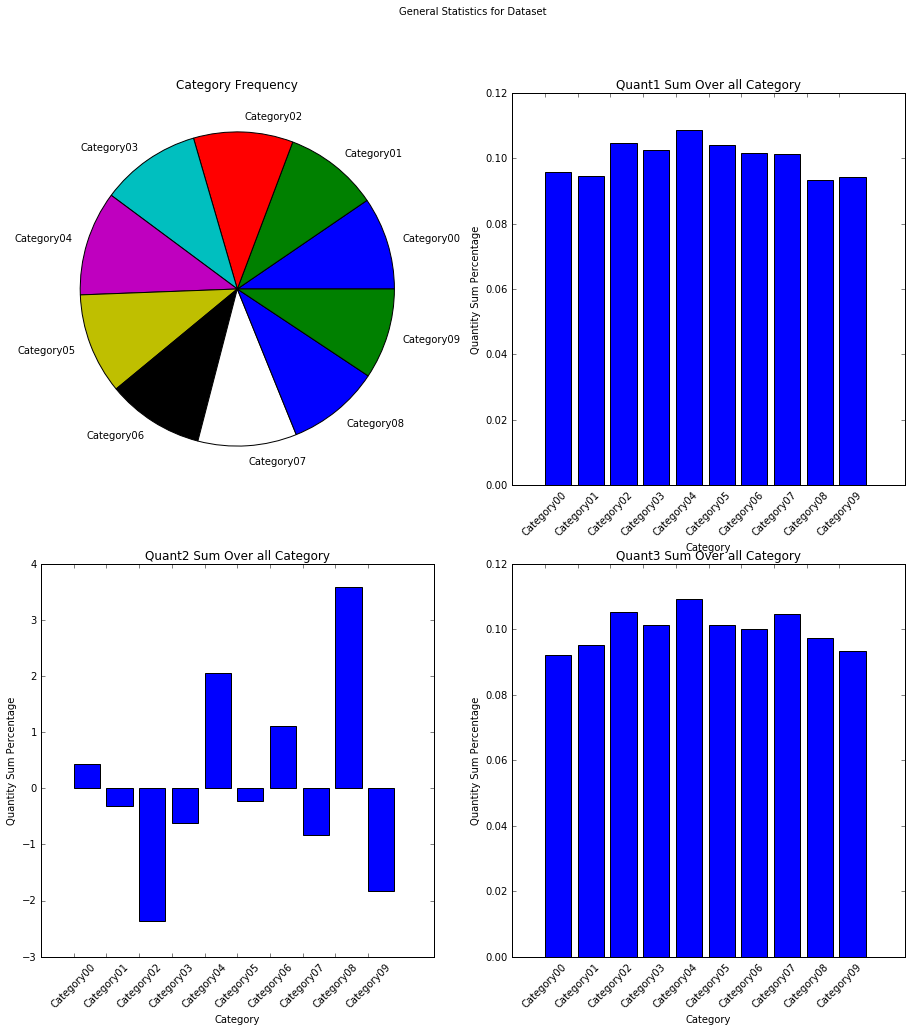

In [203]:
def generalStat(data):
    dataFig = plt.figure(figsize=(15,15))
    # make super title
    dataFig.suptitle('General Statistics for Dataset')
    # Make Pie Chart
    ax1 = dataFig.add_subplot(2,2,1)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)    
    freqCat = sample.groupby('categorical')['categorical'].count()
    ax1.pie(freqCat,labels=freqCat.index)
    ax1.set_title('Category Frequency')
    quant1sum = sample.groupby('categorical')['quant1'].sum()/sample['quant1'].sum()
    quant2sum = sample.groupby('categorical')['quant2'].sum()/sample['quant2'].sum()
    quant3sum = sample.groupby('categorical')['quant3'].sum()/sample['quant3'].sum()

    ax2 = dataFig.add_subplot(2,2,2)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)    
    ax2.bar(range(1,len(quant1sum)+1),quant1sum.values)
    ax2.set_title('Quant1 Sum Over all Category')
    ax2.set_xlabel('Category')
    ax2.set_ylabel('Quantity Sum Percentage')
    xticks = plt.xticks(range(1,len(quant1sum)+1),quant1sum.index,rotation=45)
    
    ax3 = dataFig.add_subplot(2,2,3)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)        
    ax3.bar(range(1,len(quant2sum)+1),quant2sum.values)
    ax3.set_title('Quant2 Sum Over all Category')
    ax3.set_xlabel('Category')
    ax3.set_ylabel('Quantity Sum Percentage')
    xticks = plt.xticks(range(1,len(quant2sum)+1),quant2sum.index,rotation=45)

    
    ax4 = dataFig.add_subplot(2,2,4)    
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    ax4.bar(range(1,len(quant3sum)+1),quant3sum.values)
    ax4.set_title('Quant3 Sum Over all Category')
    ax4.set_xlabel('Category')
    ax4.set_ylabel('Quantity Sum Percentage')
    xticks = plt.xticks(range(1,len(quant3sum)+1),quant3sum.index,rotation=45)
    #dataFig.tight_layout() # Or equivalently,  "plt.tight_layout()"



generalStat(sample)